# **Sentiment Analysis for Investment Strategies on Tesla Stock**

# 1. Data Collecting and Wrangling
The first step for this sentiment analysis task is to collect data. 
In order to develop data-driven investment stratefies on Tesla Stock, the Tesla stock price movesments are required. News articles published in major news sources are chosen for the sentiment analysis, assumping that the news sentiments can represent public confidence in Tesla and its stock.   

APIs are very convinent way to collect required data in this task. The following APIs are used:
* [NewsAPI](https://newsapi.org/)
* [marketstack](https://marketstack.com/)

In this task, data from the past **30 days** are evaluated. The time period is from **2023-10-12** to **2023-9-13**. This short timeframe is used for two reasons. Firstly, Tesla stock typically undergoes swift fluctuations. Secondly, the free plan from NewsAPI restricts requests to news from the most recent 30 days. Therefore, this works targets on short-term (days or weeks) investment strategies.

## 1.1. Import Libraries

In [1]:
#!pip install newsapi-python

In [59]:
from newsapi import NewsApiClient
import configparser
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json

## 1.2. News Data

### 1.2.1. Get News API Keys

In [32]:
# read newsapi key
config = configparser.ConfigParser()
config.read('config.ini')
api_key = config['newsapi']['api_key']

In [33]:
# Initiate an instance
newsapi = NewsApiClient(api_key=api_key)

In [34]:
# get available sources
sources = newsapi.get_sources()

NewsAPIException: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}

In [5]:
# check keys
sources.keys()

dict_keys(['status', 'sources'])

In [6]:
# create a list with all English sources
sources_en = []
for source in sources['sources']:
    if source['language'] != 'en':
        continue
    sources_en.append(source['id'])    

In [7]:
print('There are {} English news sources.'.format(len(sources_en)))

There are 81 English news sources.


In [9]:
# define a function to convert api outout to pandas dataframe
def json_articles_torows(json_articles): 
    # create a list for all entries
    df_rows = [] 
    for item in json_articles:
        row_dict = {}
        row_dict['source'] = item['source']
        row_dict['author'] = item['author']
        row_dict['title'] = item['title']
        row_dict['description'] = item['description']
        row_dict['url'] = item["url"]
        row_dict['photo_url'] = item['urlToImage']
        row_dict['pub_date'] = item['publishedAt']
        row_dict['content'] = item['content']
        df_rows.append(row_dict)
    return df_rows

### 1.2.2. Make Requests

In [ ]:
# define the past period of interets
daylimit = 30

In [10]:
# get the fromdate of interest
today = datetime.now().date()
fromdate = today - timedelta(days = 30)
print('News from {} until {} are used.'.format(str(fromdate), str(today)))

2023-09-12


In [28]:
# define a function to extract Tesla news from all English sources published within the past 30 dyas 
def request_tesla(sources, api_key, fromdate, sortby = 'popularity', samplesize = 100, language = 'en'):
    url = 'https://newsapi.org/v2/everything?'
    i = 0
    for source in sources:
        params_dict = {
            'q': 'Tesla',
            'sources': source,
            'sortBy': sortby,
            'pageSize': samplesize,
            'apiKey': api_key,
            'language': language,
            'from' : str(fromdate)  
        }

        # make a request 
        response = requests.get(url, params = params_dict)
    
        print('Request status code for {} is {}.'.format(source, response.status_code))
        # check the request status
        if response.status_code != 200:
            raise Exception("Request for {} returned an error: {} {}".format(source, response.status_code, response.text))

        # change response to json format
        response_json = response.json()
        print('There are total of {} articals from {} about Tesla.'.format(response_json['totalResults'], source))
        json_articles = response_json['articles']
    
        # convert to dataframe
        if i == 0:
            articles_df = pd.DataFrame(json_articles_torows(json_articles))
        else:
            new_df = pd.DataFrame(json_articles_torows(json_articles))
            articles_df = pd.concat([articles_df, new_df]).reset_index(drop = True)
        
        i += 1
    return articles_df

In [12]:
# request data
articles_df = request_tesla(sources_en, api_key, fromdate)

Request status code for abc-news is 200.
There are total of 33 articals from abc-news about Tesla.
Request status code for abc-news-au is 200.
There are total of 12 articals from abc-news-au about Tesla.
Request status code for al-jazeera-english is 200.
There are total of 7 articals from al-jazeera-english about Tesla.
Request status code for ars-technica is 200.
There are total of 14 articals from ars-technica about Tesla.
Request status code for associated-press is 200.
There are total of 1 articals from associated-press about Tesla.
Request status code for australian-financial-review is 200.
There are total of 0 articals from australian-financial-review about Tesla.
Request status code for axios is 200.
There are total of 0 articals from axios about Tesla.
Request status code for bbc-news is 200.
There are total of 12 articals from bbc-news about Tesla.
Request status code for bbc-sport is 200.
There are total of 12 articals from bbc-sport about Tesla.
Request status code for bleac

In [13]:
# check how many news in total
articles_df.shape

(898, 8)

In [14]:
articles_df.head()

,source,author,title,description,url,photo_url,pub_date,content
0,"{'id': 'abc-news', 'name': 'ABC News'}","Brittany Gaddy, Deena Zaru","EEOC sues Tesla, alleging race discrimination ...","Tesla, the electric car company, is facing acc...",https://abcnews.go.com/US/eeoc-files-federal-l...,https://i.abcnewsfe.com/a/63a26308-5b81-4b2f-b...,2023-09-28T23:53:26Z,The U.S. Equal Employment Opportunity Commissi...
1,"{'id': 'abc-news', 'name': 'ABC News'}",Max Zahn,Soaring CEO pay commands spotlight in UAW stri...,Autoworkers have demanded wage increases that ...,https://abcnews.go.com/Business/soaring-ceo-pa...,https://i.abcnewsfe.com/a/be523951-d505-41ac-b...,2023-09-16T10:04:31Z,A strike launched by thousands of autoworkers ...
2,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Turkey's President Erdogan and Elon Musk discu...,Turkish President Recep Tayyip Erdogan has cal...,https://abcnews.go.com/Technology/wireStory/tu...,https://s.abcnews.com/images/US/abc_news_defau...,2023-09-18T07:10:02Z,ISTANBUL -- Turkish President Recep Tayyip Erd...
3,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Netanyahu visits Elon Musk in California with ...,Prime Minister Benjamin Netanyahu is starting ...,https://abcnews.go.com/Technology/wireStory/ne...,https://s.abcnews.com/images/US/abc_news_defau...,2023-09-18T16:22:23Z,"SAN JOSE, Calif. -- Prime Minister Benjamin Ne..."
4,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Elon Musk facing defamation lawsuit in Texas o...,A California man who says he was harassed afte...,https://abcnews.go.com/Technology/wireStory/el...,https://i.abcnewsfe.com/a/10421d31-8c0d-47ff-8...,2023-10-02T23:02:32Z,"AUSTIN, Texas -- A California man who says he ..."


In [16]:
# check article number from each source
articles_df.source.value_counts()

{'id': 'business-insider', 'name': 'Business Insider'}                  200
{'id': 'the-times-of-india', 'name': 'The Times of India'}              100
{'id': 'fortune', 'name': 'Fortune'}                                     68
{'id': None, 'name': '[Removed]'}                                        49
{'id': 'abc-news', 'name': 'ABC News'}                                   33
{'id': 'the-jerusalem-post', 'name': 'The Jerusalem Post'}               30
{'id': 'next-big-future', 'name': 'Next Big Future'}                     30
{'id': 'cnn', 'name': 'CNN'}                                             29
{'id': 'breitbart-news', 'name': 'Breitbart News'}                       28
{'id': 'bbc-news', 'name': 'BBC News'}                                   24
{'id': 'reuters', 'name': 'Reuters'}                                     24
{'id': 'newsweek', 'name': 'Newsweek'}                                   23
{'id': 'the-irish-times', 'name': 'The Irish Times'}                     23
{'id': 'tech

In [154]:
# there is one source called [Removed] which is abnormal
articles_df[articles_df.source == {'id': None, 'name': '[Removed]'}]

,source,author,title,description,url,photo_url,pub_date,content,date,source_name,source_id
484,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
485,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
486,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
487,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
488,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
489,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
490,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
491,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
492,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None
493,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01 00:00:00+00:00,[Removed],1970-01-01,[Removed],None


In [155]:
# data are not useless, lets's remove it
articles_df = articles_df[articles_df.source != {'id': None, 'name': '[Removed]'}]

In [157]:
articles_df.shape

(849, 11)

### 1.2.3. Preliminary Data Wrangling

In [158]:
# extract date
articles_df['pub_date'] = pd.to_datetime(articles_df['pub_date'])
articles_df['date'] = articles_df['pub_date'].dt.strftime('%Y-%m-%d')
articles_df['date'] = pd.to_datetime(articles_df['date'])
articles_df.head()

,source,author,title,description,url,photo_url,pub_date,content,date,source_name,source_id
0,"{'id': 'abc-news', 'name': 'ABC News'}","Brittany Gaddy, Deena Zaru","EEOC sues Tesla, alleging race discrimination ...","Tesla, the electric car company, is facing acc...",https://abcnews.go.com/US/eeoc-files-federal-l...,https://i.abcnewsfe.com/a/63a26308-5b81-4b2f-b...,2023-09-28 23:53:26+00:00,The U.S. Equal Employment Opportunity Commissi...,2023-09-28,ABC News,abc-news
1,"{'id': 'abc-news', 'name': 'ABC News'}",Max Zahn,Soaring CEO pay commands spotlight in UAW stri...,Autoworkers have demanded wage increases that ...,https://abcnews.go.com/Business/soaring-ceo-pa...,https://i.abcnewsfe.com/a/be523951-d505-41ac-b...,2023-09-16 10:04:31+00:00,A strike launched by thousands of autoworkers ...,2023-09-16,ABC News,abc-news
2,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Turkey's President Erdogan and Elon Musk discu...,Turkish President Recep Tayyip Erdogan has cal...,https://abcnews.go.com/Technology/wireStory/tu...,https://s.abcnews.com/images/US/abc_news_defau...,2023-09-18 07:10:02+00:00,ISTANBUL -- Turkish President Recep Tayyip Erd...,2023-09-18,ABC News,abc-news
3,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Netanyahu visits Elon Musk in California with ...,Prime Minister Benjamin Netanyahu is starting ...,https://abcnews.go.com/Technology/wireStory/ne...,https://s.abcnews.com/images/US/abc_news_defau...,2023-09-18 16:22:23+00:00,"SAN JOSE, Calif. -- Prime Minister Benjamin Ne...",2023-09-18,ABC News,abc-news
4,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Elon Musk facing defamation lawsuit in Texas o...,A California man who says he was harassed afte...,https://abcnews.go.com/Technology/wireStory/el...,https://i.abcnewsfe.com/a/10421d31-8c0d-47ff-8...,2023-10-02 23:02:32+00:00,"AUSTIN, Texas -- A California man who says he ...",2023-10-02,ABC News,abc-news


In [159]:
# extract source id and name
articles_df.loc[:, 'source_name'] = [x['name'] for x in articles_df['source']]
articles_df.loc[:, 'source_id'] = [x['id'] for x in articles_df['source']]
articles_df.head()

,source,author,title,description,url,photo_url,pub_date,content,date,source_name,source_id
0,"{'id': 'abc-news', 'name': 'ABC News'}","Brittany Gaddy, Deena Zaru","EEOC sues Tesla, alleging race discrimination ...","Tesla, the electric car company, is facing acc...",https://abcnews.go.com/US/eeoc-files-federal-l...,https://i.abcnewsfe.com/a/63a26308-5b81-4b2f-b...,2023-09-28 23:53:26+00:00,The U.S. Equal Employment Opportunity Commissi...,2023-09-28,ABC News,abc-news
1,"{'id': 'abc-news', 'name': 'ABC News'}",Max Zahn,Soaring CEO pay commands spotlight in UAW stri...,Autoworkers have demanded wage increases that ...,https://abcnews.go.com/Business/soaring-ceo-pa...,https://i.abcnewsfe.com/a/be523951-d505-41ac-b...,2023-09-16 10:04:31+00:00,A strike launched by thousands of autoworkers ...,2023-09-16,ABC News,abc-news
2,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Turkey's President Erdogan and Elon Musk discu...,Turkish President Recep Tayyip Erdogan has cal...,https://abcnews.go.com/Technology/wireStory/tu...,https://s.abcnews.com/images/US/abc_news_defau...,2023-09-18 07:10:02+00:00,ISTANBUL -- Turkish President Recep Tayyip Erd...,2023-09-18,ABC News,abc-news
3,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Netanyahu visits Elon Musk in California with ...,Prime Minister Benjamin Netanyahu is starting ...,https://abcnews.go.com/Technology/wireStory/ne...,https://s.abcnews.com/images/US/abc_news_defau...,2023-09-18 16:22:23+00:00,"SAN JOSE, Calif. -- Prime Minister Benjamin Ne...",2023-09-18,ABC News,abc-news
4,"{'id': 'abc-news', 'name': 'ABC News'}",The Associated Press,Elon Musk facing defamation lawsuit in Texas o...,A California man who says he was harassed afte...,https://abcnews.go.com/Technology/wireStory/el...,https://i.abcnewsfe.com/a/10421d31-8c0d-47ff-8...,2023-10-02 23:02:32+00:00,"AUSTIN, Texas -- A California man who says he ...",2023-10-02,ABC News,abc-news


In [166]:
# keep the usefull columns
cols_keep = ['source_name', 'author', 'date', 'title', 'description', 'content']
news_df = articles_df[cols_keep]
news_df.head()

,source_name,author,date,title,description,content
0,ABC News,"Brittany Gaddy, Deena Zaru",2023-09-28,"EEOC sues Tesla, alleging race discrimination ...","Tesla, the electric car company, is facing acc...",The U.S. Equal Employment Opportunity Commissi...
1,ABC News,Max Zahn,2023-09-16,Soaring CEO pay commands spotlight in UAW stri...,Autoworkers have demanded wage increases that ...,A strike launched by thousands of autoworkers ...
2,ABC News,The Associated Press,2023-09-18,Turkey's President Erdogan and Elon Musk discu...,Turkish President Recep Tayyip Erdogan has cal...,ISTANBUL -- Turkish President Recep Tayyip Erd...
3,ABC News,The Associated Press,2023-09-18,Netanyahu visits Elon Musk in California with ...,Prime Minister Benjamin Netanyahu is starting ...,"SAN JOSE, Calif. -- Prime Minister Benjamin Ne..."
4,ABC News,The Associated Press,2023-10-02,Elon Musk facing defamation lawsuit in Texas o...,A California man who says he was harassed afte...,"AUSTIN, Texas -- A California man who says he ..."


In [167]:
# check data for missing values and data types
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 849 entries, 0 to 897
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   source_name  849 non-null    object        
 1   author       827 non-null    object        
 2   date         849 non-null    datetime64[ns]
 3   title        849 non-null    object        
 4   description  848 non-null    object        
 5   content      849 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 46.4+ KB


**Note:**
There is only missing authors, which is not a big issue for this task.

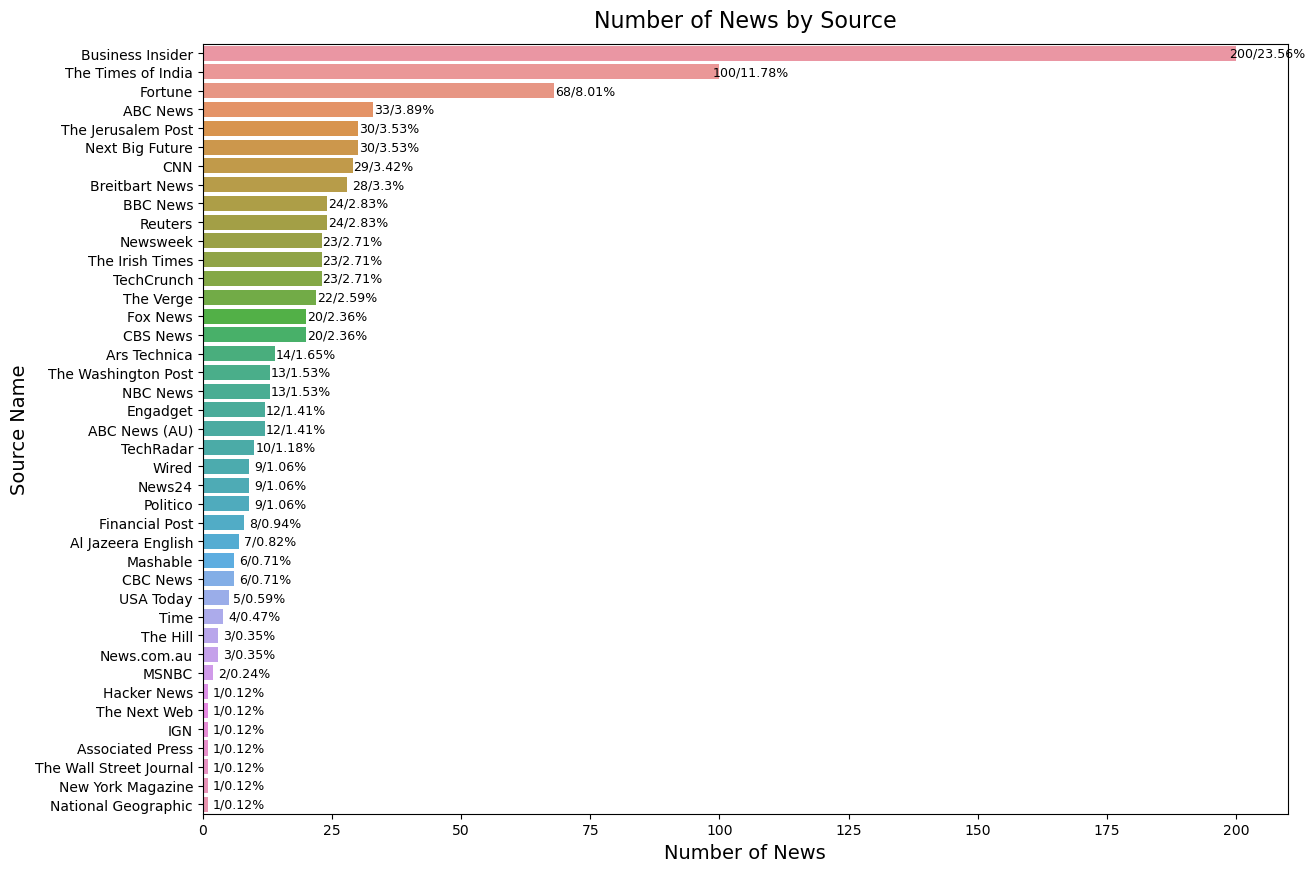

In [168]:
# let plot how many articles for each source
name_sorted = list(news_df.source_name.value_counts().index)
values_sorted = list(news_df.source_name.value_counts().values)
percents_sorted = [round(x/sum(values_sorted) * 100, 2) for x in values_sorted]

plt.figure(figsize = (14, 10))
sns.countplot(data = news_df, y = 'source_name', order = name_sorted)

for i, value in enumerate(values_sorted):
    plt.annotate('{}/{}%'.format(str(value), str(percents_sorted[i])), 
                 (value+6, i), 
                 ha = 'center', 
                 va = 'center', 
                 fontsize = 9)

plt.title('Number of News by Source', fontsize = 16, pad = 12)
plt.xlabel('Number of News', fontsize = 14)
plt.ylabel('Source Name', fontsize = 14)

plt.show()

**Note:** The variety of sources looks good.

In [170]:
# sort the news by date
news_df = news_df.sort_values(by = ['date'])
news_df.reset_index(inplace=True, drop = True)
news_df.head()

,source_name,author,date,title,description,content
0,The Jerusalem Post,By REUTERS,2023-09-12,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...
1,Business Insider,ssheth@businessinsider.com (Sonam Sheth),2023-09-12,Elon Musk learned hypnosis as a child and mana...,Elon Musk learned magic tricks and hypnosis as...,"When Elon Musk was a kid, he learned hypnosis ..."
2,ABC News,STEVE KARNOWSKI Associated Press,2023-09-12,Defense Department awards $20.6 million to pro...,The Department of Defense has awarded $20.6 mi...,MINNEAPOLIS -- The Department of Defense on Tu...
3,Fortune,Paige Hagy,2023-09-12,Elon Musk lives life like he’s playing a video...,"""Elon Musk,"" a biography that recounts the chi...",Elon Musk had just finished playing a video ga...
4,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ..."


In [171]:
news_df.tail()

,source_name,author,date,title,description,content
844,CBC News,None,2023-10-11,Canada's electronic spy agency facing a staffi...,The Communications Security Establishment (CSE...,The Communications Security Establishment (CSE...
845,Business Insider,Tim Levin,2023-10-11,"I drove a $400,000 Rolls-Royce and a $140,000 ...","Is a $400,000 Rolls-Royce really that much bet...",I tested the Mercedes-Benz S-Class (top) and R...
846,Business Insider,Alexa St. John,2023-10-11,Rivian CEO says he wouldn't buy the Cybertruck...,Rivian CEO RJ Scaringe spoke with GQ magazine ...,Carlos Delgado/Associated Press\r\n<ul><li>Riv...
847,Reuters,Giulio Piovaccari,2023-10-11,"Ford, Hyundai turn to Italian casting machine ...","Idra, an Italian aluminium casting machine mak...","TRAVAGLIATO, Italy, Oct 11 (Reuters) - Idra, a..."
848,Business Insider,Tim Levin,2023-10-11,"I drove a $400,000 Rolls-Royce and a $140,000 ...","Is a $400,000 Rolls-Royce really that much bet...",I tested the Mercedes-Benz S-Class (top) and R...


### 1.2.4. Save as CSV

In [172]:
# save out the news data
news_df.to_csv('../data/Tesla_news.csv', index = False)

## 1.3. Stock Price Data

### 1.3.1. Get MarketStack API key

In [45]:
# read market stack api key
config = configparser.ConfigParser()
config.read('config.ini')
api_key = config['marketstack']['api_key']

### 1.3.2. Make Requests

In [46]:
# how many days of data?
daylimit = 30

In [47]:
# make a request to the marketstack API to extract stock prices of Tesla
url = 'http://api.marketstack.com/v1/tickers/tsla/eod'

params = {
    'access_key' : api_key,
    'limit': daylimit,
}

response = requests.get(url, params)

 # check the request status
if response.status_code != 200:
    raise Exception("Request returned an error: {} {}".format(response.status_code, response.text))

In [48]:
# change response to json format
response_json = response.json()
response_json.keys()

dict_keys(['pagination', 'data'])

In [49]:
# check API response related to paginaion 
response_json['pagination']

{'limit': 30, 'offset': 0, 'count': 30, 'total': 251}

In [50]:
# check a sample data
response_json['data']['eod'][0]

{'open': 266.2,
 'high': 268.6,
 'low': 260.9,
 'close': 262.99,
 'volume': 103706266.0,
 'adj_high': 268.6,
 'adj_low': 260.9,
 'adj_close': 262.99,
 'adj_open': 266.2,
 'adj_volume': 103706266.0,
 'split_factor': 1.0,
 'dividend': 0.0,
 'symbol': 'TSLA',
 'exchange': 'XNAS',
 'date': '2023-10-11T00:00:00+0000'}

In [51]:
# define a function to convert api outout to pandas dataframe
def json_eods_torows(json_eods): 
    # create a list for all entries
    df_rows = [] 
    for item in json_eods:
        row_dict = {}
        row_dict['open'] = item['open']
        row_dict['high'] = item['high']
        row_dict['low'] = item['low']
        row_dict['close'] = item['close']
        row_dict['volume'] = item["volume"]
        row_dict['split_factor'] = item['split_factor']
        row_dict['dividend'] = item['dividend']
        row_dict['symbol'] = item['symbol']
        row_dict['date'] = item['date']
        df_rows.append(row_dict)
    return df_rows

In [97]:
# convert data to dataframe
df = pd.DataFrame(response_json['data']['eod'])
df.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,266.20,268.60,260.90,262.99,103706266.0,268.60,260.90,262.99,266.20,103706266.0,1.0,0.0,TSLA,XNAS,2023-10-11T00:00:00+0000
1,257.78,268.94,257.65,263.62,122656030.0,268.94,257.65,263.62,257.75,122656030.0,1.0,0.0,TSLA,XNAS,2023-10-10T00:00:00+0000
2,255.21,261.36,252.05,259.67,101377947.0,261.36,252.05,259.67,255.31,101377947.0,1.0,0.0,TSLA,XNAS,2023-10-09T00:00:00+0000
3,253.98,261.65,250.65,260.53,118121812.0,261.65,250.65,260.53,253.98,118121812.0,1.0,0.0,TSLA,XNAS,2023-10-06T00:00:00+0000
4,260.00,263.60,256.25,260.05,119159214.0,263.60,256.25,260.05,260.00,119159214.0,1.0,0.0,TSLA,XNAS,2023-10-05T00:00:00+0000


In [98]:
# check if there is any missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          30 non-null     float64
 1   high          30 non-null     float64
 2   low           30 non-null     float64
 3   close         30 non-null     float64
 4   volume        30 non-null     float64
 5   adj_high      30 non-null     float64
 6   adj_low       30 non-null     float64
 7   adj_close     30 non-null     float64
 8   adj_open      30 non-null     float64
 9   adj_volume    30 non-null     float64
 10  split_factor  30 non-null     float64
 11  dividend      30 non-null     float64
 12  symbol        30 non-null     object 
 13  exchange      30 non-null     object 
 14  date          30 non-null     object 
dtypes: float64(12), object(3)
memory usage: 3.6+ KB


### 1.3.3. Preliminary Data Wrangling

In [99]:
# create a date column
df['datetime'] = pd.to_datetime(df['date'])
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'])
df.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date,datetime
0,266.20,268.60,260.90,262.99,103706266.0,268.60,260.90,262.99,266.20,103706266.0,1.0,0.0,TSLA,XNAS,2023-10-11,2023-10-11 00:00:00+00:00
1,257.78,268.94,257.65,263.62,122656030.0,268.94,257.65,263.62,257.75,122656030.0,1.0,0.0,TSLA,XNAS,2023-10-10,2023-10-10 00:00:00+00:00
2,255.21,261.36,252.05,259.67,101377947.0,261.36,252.05,259.67,255.31,101377947.0,1.0,0.0,TSLA,XNAS,2023-10-09,2023-10-09 00:00:00+00:00
3,253.98,261.65,250.65,260.53,118121812.0,261.65,250.65,260.53,253.98,118121812.0,1.0,0.0,TSLA,XNAS,2023-10-06,2023-10-06 00:00:00+00:00
4,260.00,263.60,256.25,260.05,119159214.0,263.60,256.25,260.05,260.00,119159214.0,1.0,0.0,TSLA,XNAS,2023-10-05,2023-10-05 00:00:00+00:00


In [100]:
# check data type again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   open          30 non-null     float64            
 1   high          30 non-null     float64            
 2   low           30 non-null     float64            
 3   close         30 non-null     float64            
 4   volume        30 non-null     float64            
 5   adj_high      30 non-null     float64            
 6   adj_low       30 non-null     float64            
 7   adj_close     30 non-null     float64            
 8   adj_open      30 non-null     float64            
 9   adj_volume    30 non-null     float64            
 10  split_factor  30 non-null     float64            
 11  dividend      30 non-null     float64            
 12  symbol        30 non-null     object             
 13  exchange      30 non-null     object             
 14  date        

In [101]:
# sort by date ascendingly
df = df.sort_values(by = ['date'])
df.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date,datetime
29,254.200,260.5100,250.59,256.90,121988437.0,260.5100,250.59,256.90,254.200,121988437.0,1.0,0.0,TSLA,XNAS,2023-08-30,2023-08-30 00:00:00+00:00
28,255.980,261.1800,255.05,258.08,108861698.0,261.1800,255.05,258.08,255.980,108861698.0,1.0,0.0,TSLA,XNAS,2023-08-31,2023-08-31 00:00:00+00:00
27,257.260,259.0794,242.01,245.01,132541640.0,259.0794,242.01,245.01,257.260,132541640.0,1.0,0.0,TSLA,XNAS,2023-09-01,2023-09-01 00:00:00+00:00
26,245.000,258.0000,244.86,256.49,129469565.0,258.0000,244.86,256.49,245.000,129469565.0,1.0,0.0,TSLA,XNAS,2023-09-05,2023-09-05 00:00:00+00:00
25,255.135,255.3900,245.06,251.92,116959759.0,255.3900,245.06,251.92,255.135,116959759.0,1.0,0.0,TSLA,XNAS,2023-09-06,2023-09-06 00:00:00+00:00


**Note:** The stock market closes on holidays and weekends. `date` columns is not continuous.

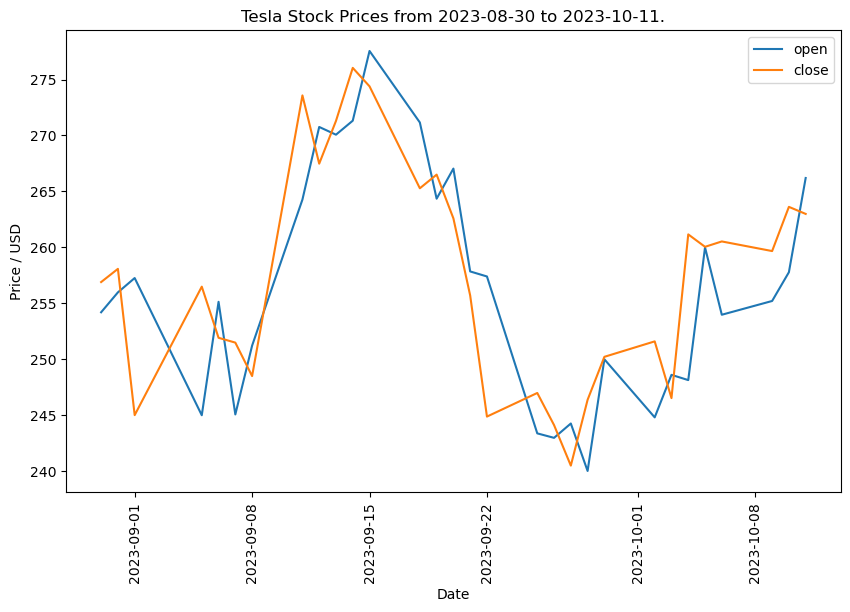

In [111]:
# let's plot the daily open and close 
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['open'])
plt.plot(df['date'], df['close'])

plt.legend(['open', 'close'])
plt.xticks(rotation = 90)

plt.title('Tesla Stock Prices from {} to {}.'.format(str(df['date'].min()).split()[0], str(df['date'].max()).split()[0]))
plt.xlabel('Date')
plt.ylabel('Price / USD')

plt.show()

In [103]:
# calculate stock price movements within a day and compared to previous day
df['inday_move'] = df['close'] - df['open']
df.set_index('date', inplace = True)
df['yesterday_move'] = df['close'].diff()
df.reset_index(inplace = True)
df.head()

,date,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,datetime,inday_move,yesterday_move
0,2023-08-30,254.200,260.5100,250.59,256.90,121988437.0,260.5100,250.59,256.90,254.200,121988437.0,1.0,0.0,TSLA,XNAS,2023-08-30 00:00:00+00:00,2.700,NaN
1,2023-08-31,255.980,261.1800,255.05,258.08,108861698.0,261.1800,255.05,258.08,255.980,108861698.0,1.0,0.0,TSLA,XNAS,2023-08-31 00:00:00+00:00,2.100,1.18
2,2023-09-01,257.260,259.0794,242.01,245.01,132541640.0,259.0794,242.01,245.01,257.260,132541640.0,1.0,0.0,TSLA,XNAS,2023-09-01 00:00:00+00:00,-12.250,-13.07
3,2023-09-05,245.000,258.0000,244.86,256.49,129469565.0,258.0000,244.86,256.49,245.000,129469565.0,1.0,0.0,TSLA,XNAS,2023-09-05 00:00:00+00:00,11.490,11.48
4,2023-09-06,255.135,255.3900,245.06,251.92,116959759.0,255.3900,245.06,251.92,255.135,116959759.0,1.0,0.0,TSLA,XNAS,2023-09-06 00:00:00+00:00,-3.215,-4.57


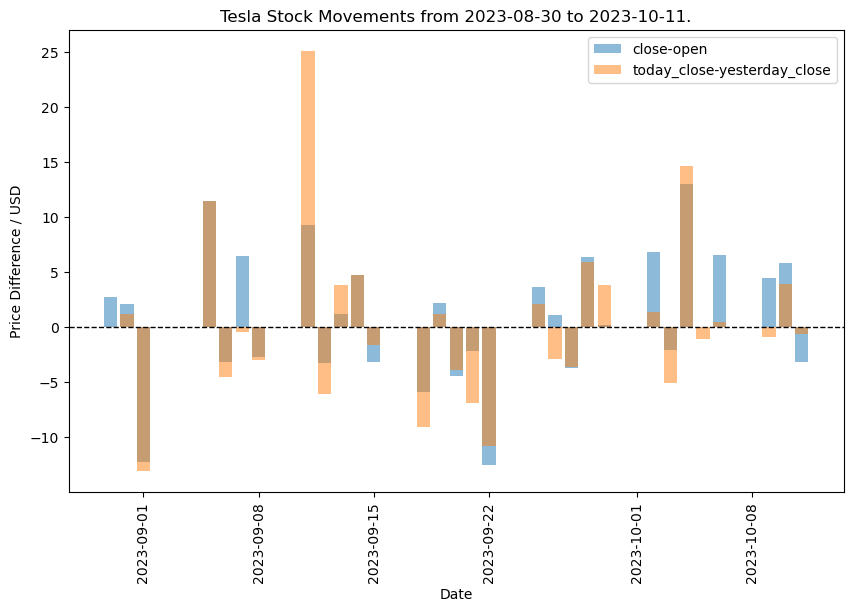

In [110]:
# plot the movements

plt.figure(figsize=(10, 6))
plt.bar(df['date'], df['inday_move'], alpha = 0.5)
plt.bar(df['date'], df['yesterday_move'], alpha = 0.5)

plt.legend(['close-open', 'today_close-yesterday_close'])
plt.xticks(rotation = 90)

plt.axhline(y=0, color = 'k', linestyle = '--', linewidth = 1)

plt.title('Tesla Stock Movements from {} to {}.'.format(str(df['date'].min()).split()[0], str(df['date'].max()).split()[0]))
plt.xlabel('Date')
plt.ylabel('Price Difference / USD')

plt.show()

**Note:**
* Most of the time, the open price is close to close price yesterday. Therefore, the close price change to yesterday shows similar trend to inday change.
* However, due to after-hours trading, news, dividens and other factors, the opening price can be different from its closing price on the previous trading day.
* Closing price change compared to yesterday is a better indicator for our task. It reflects all impacts from both open-hours and after-hours.

### 1.3.4. Save as CSV

In [113]:
# save out the stock price data
df.to_csv('../data/Tesla_stock.csv', index = False)